<a href="https://colab.research.google.com/github/donw7/neural_activity_models_DNNs/blob/main/decode_behavior_from_neural_activity_DNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decoding decision-making behavior from neural activity
This is a comparison of statistical models vs. deep neural networks (DNNs), their performances across different conditions and with various types of data and hyperparameters.

## Hypotheses:
1. Decision-making behavior can be predicted reasonably well from information encoded in neural activity, even with small datasets
2. DNNs outperform statistical models but are prone to overfitting and require additional considerations, e.g. regularization

## Procedures:
1. Simulate neural data as validation of models to be used later with more complicated real neural data
2. Apply logistic regression
3. Apply recurrent neural networks (RNNs) and other DNNs
4. Compare DNNs to statistical models
5. Experimentation with optimizing hyperparameters

## Results & Conclusions summary:
- Complicated decision-making behavior can be predicted reasonably well from information encoded in neural activity, even with small and potentially noisy real-world datasets
- DNNs outperform statistical models (logistic regression accuracy 30-40% whereas DNNs 50-60% vs. 30% expected by chance)
- DNNS are prone to overfitting and require additional considerations, e.g. crossvalidation or regularization
- XGBoost appears to be the best performing DNN (67% accuracy vs. 30% expected by chance)

## Future directions:
- further validation
- more systmatic hyperparameter tuning, e.g. grid search
- compare with other models, e.g. KNNs, SVM
- generalize to other types of data and conditions, such as EEG data in decision-making tasks
- prediction of real-time dynamics and how this may affect the performance of DNNs, e.g. less structural and more sequential information

## Acknowledgements:
- basic notebook adapted from KordingLab, with added data, analyses, and custom scripts, visualizations
- real neural activity data from Steinmetz et al., 2019

## Preliminaries

In [1]:
# testing comment from VS code
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
import warnings

import sklearn
import torch
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

In [2]:
# import custom modules
import generate
import decoders
warnings.filterwarnings('ignore')

# simulate some
Since the goal is to analyze complicated real neural data, which would be less well-validated and subject to more noisy real world conditions, it would be prudent to start with analysis of a simple datasets such as simulated data to validate the models first - technical issues can thus be ruled out if results are negative.

In [3]:
# generate some simulated trial & neural data (drift diffusion model)
n_trials = 250
n_neurons = 10
n_bins_per_trial = 50

neural_recordings, decisions = generate.neural_data(n_trials,
                                                    n_neurons,
                                                    n_bins_per_trial)

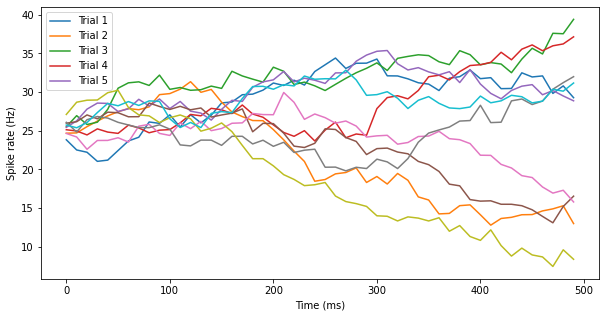

In [4]:
# plot out some trials for one neuron
neuron_id = 0

plt.figure(figsize=(10,5))
plt.plot(np.arange(0,500,10),neural_recordings[:10,neuron_id,:].T)
plt.xlabel("Time (ms)")
plt.ylabel("Spike rate (Hz)")
plt.legend(["Trial {}".format(i) for i in range(1,6)])

## initial models 

In [ ]:
from sklearn import linear_model

In [70]:
# predict each decision using all neurons's activity throughout the trials

# linear regression
X = np.reshape(neural_recordings, (n_trials,-1))
my_naive_model = linear_model.LinearRegression()

# fit
my_naive_model.fit(X, decisions)

#score
print("R2 was", my_naive_model.score(X,decisions))

R2 was 1.0


In [67]:
# electrophysiology data
new_neural_recordings, new_decisions = generate.neural_data(n_trials, 
                                             n_neurons, n_bins_per_trial)
new_X = np.reshape(new_neural_recordings, (n_trials,-1))

# score
print("R2 was",my_naive_model.score(new_X,new_decisions))

R2 was 0.2869450572534453


In [65]:
# initalize logistic regression model
log_reg = linear_model.LogisticRegression(penalty='none', solver = 'lbfgs',
                                          max_iter = 1000)
# fit
log_reg.fit(new_X, new_decisions)

# score
print("R2 was",log_reg.score(new_X,new_decisions))

R2 was 1.0


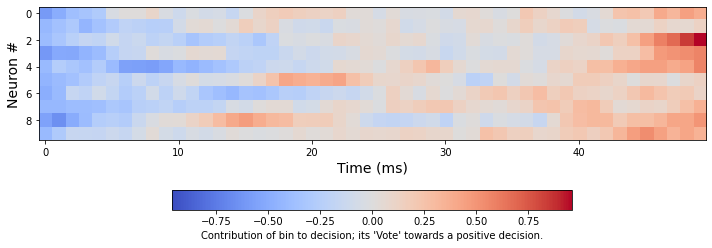

In [57]:
def plot_coefs(fit_model):
  """Makes a nice plot of the coefficients. fit_model is the model instance after fitting."""
  # get the coefficients of your fit
  coefficients = fit_model.coef_.reshape(n_neurons, n_bins_per_trial)

  # show them
  plt.figure(figsize = (10,5))
  plt.imshow(coefficients, cmap = 'coolwarm', vmin = -np.max(coefficients), 
                                              vmax = np.max(coefficients))

  #make it pretty
  plt.ylabel("Neuron #", fontsize = 14)
  plt.xlabel("Time (ms)", fontsize = 14)
  plt.colorbar(orientation = 'horizontal', shrink = .6, 
               label="Contribution of bin to decision; its 'Vote' towards a positive decision.")
  plt.tight_layout()
  plt.show()
  
plot_coefs(log_reg)

## Crossvalidation

In [ ]:
split = int(n_trials*4/5)

In [ ]:
idxtrain = random.sample(range(0, n_trials), split)
idxval = np.setdiff1d(range(0, n_trials), idxtrain)
print(idxtrain)
print('\n')
print(idxval)

In [ ]:
training_data = new_neural_recordings[idxtrain,:,:]
validation_data = new_neural_recordings[idxval,:,:]

training_decisions = new_decisions[idxtrain]
validation_decisions = new_decisions[idxval]

new_X_cv = np.reshape(training_data, (split,-1))

In [ ]:
training_data[1:2,:]

In [61]:
# initalize the model
log_reg = linear_model.LogisticRegression(penalty='none', solver = 'lbfgs',
                                          max_iter = 1000)
# fit
log_reg.fit(new_X_cv, training_decisions)

# fit and score on training
print("R2 was",log_reg.score(new_X_cv,training_decisions))


R2 was 1.0


In [62]:
# k-fold CV
def get_test_train_splits(data, decisions, n_folds=5):
  """
  Returns a tuple of matched train sets and validation sets, rotating through the data.
  
  Note that there are scikit-learn functions that do this, too."""
  
  fold_size = len(data)//n_folds
  
  training_sets = [np.roll(data,fold_size*i, axis=0)[fold_size:] for i in range(n_folds)]
  val_sets = [np.roll(data,fold_size*i, axis=0)[:fold_size] for i in range(n_folds)]
  
  training_Y = [np.roll(decisions,fold_size*i, axis=0)[fold_size:] for i in range(n_folds)]
  val_Y = [np.roll(decisions,fold_size*i, axis=0)[:fold_size] for i in range(n_folds)]
  

  return (training_sets, training_Y), (val_sets, val_Y)

Fold 0 of 5
   Validation accuracy of 0.9
   True test set accuracy of 0.892


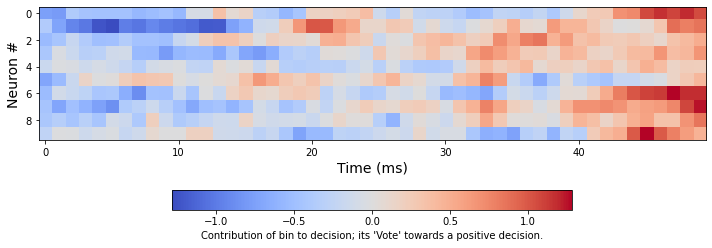

Fold 1 of 5
   Validation accuracy of 0.92
   True test set accuracy of 0.876


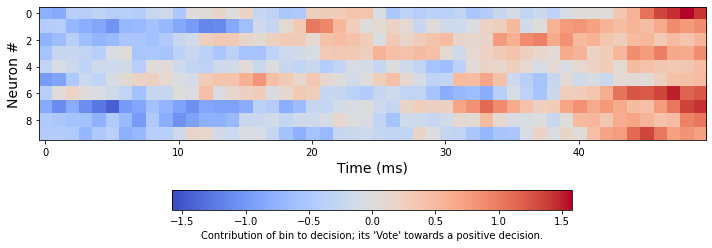

Fold 2 of 5
   Validation accuracy of 0.92
   True test set accuracy of 0.904


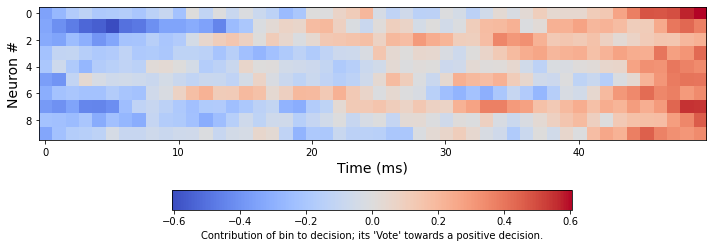

Fold 3 of 5
   Validation accuracy of 0.92
   True test set accuracy of 0.892


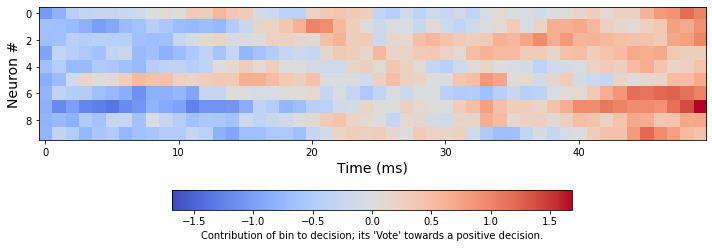

Fold 4 of 5
   Validation accuracy of 0.92
   True test set accuracy of 0.9


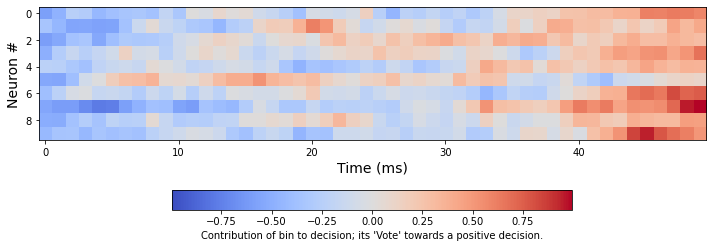

Mean validation accuracy: 0.916


In [63]:
(training_sets, training_Ys), (val_sets, val_Ys) = get_test_train_splits(X, decisions)

scores = []

# Iterate through the k=5 folds
for fold in range(5):
  print("Fold {} of 5".format(fold))
  
  training_X = training_sets[fold]
  training_Y = training_Ys[fold]
  
  validation_X = val_sets[fold]
  validation_Y = val_Ys[fold]
  
  # re-initialize the logistic regression model
  this_model = linear_model.LogisticRegression(penalty='none', solver = 'lbfgs',
                                               max_iter = 1000)
  # fit and score on training
  this_model.fit(training_X, training_Y)
  this_model.score(training_X,training_Y)

  # score on the validation data
  this_accuracy = this_model.score(validation_X,validation_Y)
  scores.append(this_accuracy)
  
  # score on the new dataset (new_X, new_decisions from above)
  accuracy_on_test_data = this_model.score(new_X,new_decisions)
  
  print("   Validation accuracy of {}".format( this_accuracy ))
  print("   True test set accuracy of {}".format( accuracy_on_test_data ))
  plot_coefs(this_model)
  
print("Mean validation accuracy: {}".format(np.mean(scores)))

Regularization


In [ ]:
(training_sets, training_Ys), (val_sets, val_Ys) = get_test_train_splits(X, decisions)

scores = []

# Iterate through the k=5 folds
for fold in range(5):
    print("Fold {} of 5".format(fold))

    training_X = training_sets[fold]
    training_Y = training_Ys[fold]

    validation_X = val_sets[fold]
    validation_Y = val_Ys[fold]

    this_model = linear_model.LogisticRegression(penalty='l2', solver = 'lbfgs',
                                                 max_iter = 1000, C=1e-6)
    # fit and score on training
    this_model.fit(training_X, training_Y)
    this_model.score(training_X,training_Y)

    # score on the validation data
    this_accuracy = this_model.score(validation_X,validation_Y)
    scores.append(this_accuracy)

    # score on the new dataset (new_X, new_decisions from above)
    accuracy_on_test_data = this_model.score(new_X,new_decisions)

    print("   Validation accuracy of {}".format( this_accuracy ))
    print("   True test set accuracy of {}".format( accuracy_on_test_data ))
    plot_coefs(this_model)

print("Mean validation accuracy: {}".format(np.mean(scores)))

#### Choose the best regularization penalty, 'C'

In [ ]:
# First complete this function that takes data (e.g. X) 
# and a model, and returns the average validation accuracy from 5-fold CV
# (Largely copy and past from above, but deleting print statements)
def get_kfold_validation_score(data, decisions, C):
  (training_sets, training_Ys), (val_sets, val_Ys) = get_test_train_splits(data, decisions)

  scores = []

# Iterate through the k=5 folds
  for fold in range(5):
    training_X = training_sets[fold]
    training_Y = training_Ys[fold]

    validation_X = val_sets[fold]
    validation_Y = val_Ys[fold]

    # Redefine the logistic regression model. (important to do this inside the loop)
    this_model = linear_model.LogisticRegression(penalty='l2', solver = 'lbfgs',
                                                max_iter = 1000, C=C)
    # fit and score on training
    this_model.fit(training_X, training_Y)
    this_model.score(training_X,training_Y)

    # score on the validation data
    this_accuracy = this_model.score(validation_X,validation_Y)
    scores.append(this_accuracy)

    # score on the new dataset (new_X, new_decisions from above)
    accuracy_on_test_data = this_model.score(new_X,new_decisions)  

    
  
  return np.mean(scores)

test various values of `C` and see what's the best.


In [ ]:
# decide on a logarithmic schedule of Cs. 
Cs_to_test = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]

validation_accuracy_vs_C = []
for C in Cs_to_test:
  
  # get the mean score on k-fold cross-validation using your function above
  mean_validation_accuracy = get_kfold_validation_score(X, decisions, C)
  
  validation_accuracy_vs_C.append(mean_validation_accuracy)
  
  

In [ ]:
# plot
plt.semilogx(Cs_to_test, validation_accuracy_vs_C,"o-")
plt.xlabel("C",fontsize=16)
plt.ylabel("validation acc.",fontsize=16)
plt.ylim([.8,1])

## Applying recurrent neural networks

The shape of the training inputs is now **3-dimensional** to model effect of time. n_trials x n_neurons x n_timebins

In [ ]:
# lets re-split our original 3-dimensional trials/neurons/time input data.
split = int(n_trials*4/5)

training_data = neural_recordings[:split]
validation_data = neural_recordings[split:]

training_decisions = decisions[:split]
validation_decisions = decisions[split:]

training_data = np.swapaxes(training_data, 1, 2)
validation_data = np.swapaxes(validation_data, 1, 2)

print("Training input data is of shape", training_data.shape)
print("Validation input data is of shape", validation_data.shape)


In [ ]:
# instantiate the decoder
my_RNN_classifier = decoders.SimpleRNNClassification(units = 50,
                                                    dropout = 0,
                                                    num_epochs =250,
                                                    verbose = 1)

In [ ]:
# fit
my_RNN_classifier.fit(training_data, training_decisions)

In [ ]:
# predict
predictions = my_RNN_classifier.predict(validation_data)
predictions

In [ ]:
#my_RNN_classifier.score(validation_data, validation_decisions)
accuracy = np.sum(predictions == validation_decisions) / len(predictions)
print(accuracy)


#### RNN hyperparameter tuning

## Compare many methods on real neural data

### Preliminaries

remember to check GPU runtime

In [ ]:
!pip install googledrivedownloader

from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1W3TwEtC0Z6Qmbfuz8_AWRiQHfuDb9FIS',
                                    dest_path='./Binned_data.zip',
                                    unzip=True)


In [ ]:
binned_spikes = np.load('binned_spikes.npy')
choices = np.load('choices.npy')+1


### Predicting choices from neural population recordings

Try to predict the mouse's choices from the neuropixel recordings in the 1 second preceeding each choice. `binned_spikes.npy` is a numpy array containing the binned spike rates, and `choices.npy` contains the animal's choices. 

There are 228 trials, 1089 neurons, and 50 bins per trial (for a time of 20ms per bin).





In [ ]:
print(binned_spikes.shape, choices.shape)
print(choices[:10])

In [ ]:
# split training and validation data
split = int(len(binned_spikes)*4/5)

training_spikes = binned_spikes[:split]
validation_spikes = binned_spikes[split:]

training_choices = choices[:split]
validation_choices = choices[split:]

In [ ]:
my_RNN_classifier = decoders.SimpleRNNClassification(units = 100,
                                                    dropout = 0,
                                                    num_epochs =10,
                                                    verbose = 1)

my_RNN_classifier.fit(training_spikes, training_choices)


predictions = my_RNN_classifier.predict(validation_spikes)
accuracy = np.sum(predictions == validation_choices) / float(len(predictions))

print("\n validation accuracy: {} %".format(100*accuracy))


Fit each of the following decoders:

1.   A Gated Recurrent Unit (`decoders.GRUClassification`)
2.   An LSTM (`decoders.LSTMClassification`)
3.   Gradient boosted trees (XGBoost) (`decoders.XGBoostClassification`)





In [ ]:
# GRU
GRU_classifier = decoders.GRUClassification(units = 100,
                                              dropout = .1,
                                              num_epochs = 20,
                                              verbose = 1)

GRU_classifier.fit(training_spikes, training_choices)


In [ ]:
# accuracy 
predictions = GRU_classifier.predict(validation_spikes)
accuracy = np.sum(predictions == validation_choices) / len(predictions)
print(accuracy)


In [ ]:
#LSTM
LSTM_classifier = decoders.LSTMClassification(units = 100, 
                                              dropout = 0.1,
                                              num_epochs = 20,
                                              verbose = 1)

LSTM_classifier.fit(training_spikes, training_choices)

In [ ]:
# accuracy
predictions = LSTM_classifier.predict(validation_spikes)
accuracy = np.sum(predictions == validation_choices) / len(predictions)
print(accuracy)

In [ ]:
# XGBoost

# XGBoost is powerful but does not model time dependencies.
# Like for the logistic regression above, we have to flatten
# the inputs into shape (n_trials, n_neurons x n_time_bins)

flat_train_data = np.reshape(training_spikes, (len(training_spikes),-1)) # keep first dim, flatten rest
flat_val_data = np.reshape(validation_spikes, (len(validation_spikes),-1))


# now train it like above
XGBoost_classifier = decoders.XGBoostClassification()

XGBoost_classifier.fit(flat_train_data, training_choices)

# accuracy
predictions = XGBoost_classifier.predict(flat_val_data)
accuracy = np.sum(predictions == validation_choices) / len(predictions)
print(accuracy)



# try autosklearn, hyperopt, or gridsearch


# validate and re-run with neuropixels data


This will take about 30 seconds to download the ~600M of data into your working folder, and 10 minutes to run the script.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd '/content/drive/MyDrive/code_gdrive/neural_activity_models_DNNs/'
%ls

In [ ]:
session = "Cori_2016-12-14/"

!wget -np -r -nv http://data.cortexlab.net/taskData/$session
!mv data.cortexlab.net/taskData/ .

Now we'll extract this data into Python in the form of a dictionary.

In [ ]:
from tqdm import tqdm as tqdm

def load_data(session):
    """Takes a session in relative path ./taskData and loads it as a dictionary."""
    files = !ls taskData/$session/*.npy
    all_files = {}
    for file in files:
        filename = file.split("/")[2][:-4]
        all_files[filename] = np.load(file)
    return all_files
  
def count_neurons(time_interval, all_files):
    """In this time interval, return the neurons with nonzero spikes, and how many
    
    Returns (ids, counts)
    """
    
    
    t1,t2 = time_interval
    
    trial_spikes = all_files['spikes.times']

    interval = (trial_spikes > t1) & (trial_spikes < t2)

    trial_spikes = trial_spikes[interval]
    ids = all_files['spikes.clusters'][interval]
    
    # ids has all the info we need
    return np.unique(ids, return_counts = True)
    
    


def bin_into_array(all_files, time_before_response=1, n_bins = 50):
    
    ids = all_files['spikes.clusters']
    idList = np.unique(ids)
    
    n_trials = len(all_files['trials.response_choice'])
    n_neurons = len(idList)
    
    choices = np.reshape(all_files['trials.response_choice'],-1)
    data = np.zeros((n_trials, n_neurons, n_bins))
    
    time_resolution = time_before_response/ float(n_bins)
    print(time_resolution)
    
    for trial in tqdm(range(n_trials)):
        end_time = all_files['trials.response_times'][trial]
        start_time = end_time - time_before_response
        
        print(time_resolution)
        
        for b in range(n_bins):
        
            which_neurons, n_spikes = count_neurons((start_time + b*time_resolution,
                                            start_time + (b+1)*time_resolution),
                                          all_files)
            
            data[trial,which_neurons,b] = n_spikes
            
    return data, choices


In [ ]:
session = "Cori_2016-12-14"
all_files = load_data(session)


In [ ]:
data, choices = bin_into_array(all_files)
data.shape

In [ ]:
#clean up the data we aren't using
!rm -r data.cortexlab.net/

### grid search for hyperparameters

In [ ]:
# data = np.zeros((n_trials, n_neurons, n_bins))

# k-fold cv

# logistic regression
# RNN
# LSTM, GRU, XGBoost


In [ ]:
# get training and validation data
(training_Xs, training_Ys), (val_Xs, val_Ys) = get_test_train_splits(data, choices)
print(len(training_Xs[0]))

In [58]:
# 5-fold logistic regression
scores = []
for fold in range(5):
    print("Fold {} of 5".format(fold))

    training_X = np.reshape(training_Xs[fold], (len(training_Xs[fold]), -1))
    training_Y = np.reshape(training_Ys[fold], (len(training_Ys[fold]), -1))
    validation_X = np.reshape(val_Xs[fold], (len(val_Xs[fold]), -1))
    validation_Y = np.reshape(val_Ys[fold], (len(val_Ys[fold]), -1)) 

    this_model = linear_model.LogisticRegression(penalty='l2',
                                                 solver = 'lbfgs',
                                                 max_iter = 1000,
                                                 C=1e-6)
    # fit and score on training
    this_model.fit(training_X, training_Y)
    train_accuracy = this_model.score(training_X,training_Y)

    # score on the validation data
    val_accuracy = this_model.score(validation_X,validation_Y)
    scores.append(this_accuracy)

    print("   training set accuracy of {}".format( train_accuracy ))
    print("   validation set accuracy of {}".format( val_accuracy ))

print("Mean validation accuracy: {}".format(np.mean(scores)))

Fold 0 of 5


NameError: name 'training_Xs' is not defined

In [ ]:
def compute_accuracy(val_spikes, val_choices, model):
  predictions = model.predict(val_spikes)
  accuracy = np.sum(predictions == val_choices) / len(predictions)
  return accuracy

In [ ]:
# 5-fold RNN, GRU, LSTM, XBoost comparison
scores = {'RNN': [], 'GRU': [], 'LSTM': [], 'XB': []}
for fold in range(5):
    print("Fold {} of 5".format(fold))
    # by fold
    training_X = training_Xs[fold]
    training_Y = training_Ys[fold]
    validation_X = val_Xs[fold]
    validation_Y = val_Ys[fold]
    #flattened
    training_X_flat = np.reshape(training_Xs[fold], (len(training_Xs[fold]), -1))
    training_Y_flat = np.reshape(training_Ys[fold], (len(training_Ys[fold]), -1))
    validation_X_flat = np.reshape(val_Xs[fold], (len(val_Xs[fold]), -1))
    validation_Y_flat = np.reshape(val_Ys[fold], (len(val_Ys[fold]), -1)) 

    RNN = decoders.SimpleRNNClassification(units = 1000,
                                            dropout = 0.1,
                                            num_epochs =20,
                                            verbose = 1)
    # fit and score on training data
    RNN.fit(training_X, training_Y)
    RNN_train_accuracy = compute_accuracy(training_X, training_Y, RNN)

    # score on the validation data
    RNN_val_accuracy = compute_accuracy(validation_X, validation_Y, RNN)
    scores['RNN'].append(RNN_val_accuracy)

    print("RNN training set accuracy: {}".format(RNN_train_accuracy))
    print("RNN validation set accuracy: {}".format(RNN_val_accuracy))

print("Mean validation accuracy: {}".format(np.mean(scores['RNN'])))

